## Importing libraries and datasets

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

The datasets that will be imported are cleaned versions of the ones originally provided. Where with 'cleaned' we mean that half of the columns have been removed. However there is no substatial difference in the data contained. <br>
Additionally, we create a dummy for each dataset to signal which city it represents.

In [2]:
# Dataset is (75) 37 cols, I reset the max columns displayed
pd.set_option('display.max_columns', 37) 

ams = pd.read_csv("data/amsterdam.csv")
ams['Amsterdam'] = 1 
rott = pd.read_csv("data/rotterdam.csv")
rott['Rotterdam'] = 1
hague = pd.read_csv("data/hague.csv")
hague['Hague'] = 1

dfs = [ams, rott, hague]

# Typecast price into float
for df in dfs: # price was a string variable
    df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)

hague = hague[hague['price']<30000] # remove outliers in the hague, avg price was like $10000 

df_tot = pd.concat([ams, rott, hague], axis = 0) # We concatenate the three datasets into a single one.

df_tot['Amsterdam'] = df_tot['Amsterdam'].fillna(0) # Introduce city dummies
df_tot['Hague'] = df_tot['Hague'].fillna(0)
df_tot['Rotterdam'] = df_tot['Rotterdam'].fillna(0)

df_tot['n_amen'] = df_tot['amenities'].apply(len) # get number of amenities for the analysis
df_tot['ppp'] = df_tot['price']/df_tot['accommodates'] # get info about price per person
df_tot['host_is_superhost'] = df_tot['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0) # recode superhost for future analyses

print(f"Dim AMS: {ams.shape}\nDim Rott:{rott.shape}\nDim Hague:{hague.shape}") # get the final shape of the single datasets
print(f"Total dims: {df_tot.shape} ")

Dim AMS: (8945, 36)
Dim Rott:(1091, 34)
Dim Hague:(991, 36)
Total dims: (11027, 40) 


In [3]:
# This code is necessary to run the "additional code section"
def determine_city(row):
    if row['Amsterdam'] == 1:
        return 'Amsterdam'
    elif row['Rotterdam'] == 1:
        return 'Rotterdam'
    elif row['Hague'] == 1:
        return 'Hague'
    else:
        return 'Unknown'

# Apply the function to create the 'city' column
df_tot['city'] = df_tot.apply(determine_city, axis=1)


## Exploratory Data Analysis

Get summary statistics with the `describe` method.

In [4]:
#ams.describe

In [5]:
#rott.describe

In [6]:
#hague.describe

In [7]:
#df_tot.describe

#### Boxplot of the prices across cities

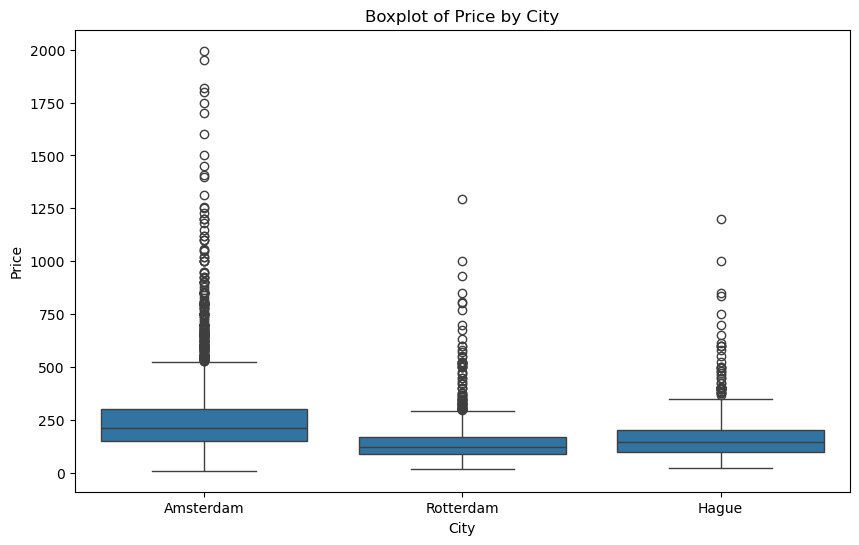

In [8]:
# Melt the DataFrame to long format
df_melted = df_tot.melt(id_vars=['price'], value_vars=['Amsterdam', 'Rotterdam', 'Hague'], 
                        var_name='city', value_name='is_city')
df_melted = df_melted[df_melted['price']<2000] # hard trim the outliers
df_melted = df_melted[df_melted['is_city'] == 1]  # keep only rows where is_city is 1

# Boxplotsss
plt.figure(figsize=(10, 6))
sns.boxplot(x='city', y='price', data=df_melted)
plt.title('Boxplot of Price by City')
plt.xlabel('City')
plt.ylabel('Price')
plt.show()

#### What variables are correlated with price?

In [9]:
num_var = df_tot.select_dtypes(include='number')
correlation_matrix = num_var.corr()

# Extract correlations for the 'price' column
price_correlation = correlation_matrix['price'].drop('price')

# Sort the correlations by absolute value in descending order
sorted_price_correlation = price_correlation.abs().sort_values(ascending=False)

print("Variables most correlated with price:")
print(sorted_price_correlation)

Variables most correlated with price:
ppp                            0.784979
accommodates                   0.345007
beds                           0.243865
n_amen                         0.228157
Amsterdam                      0.186965
reviews_per_month              0.164352
number_of_reviews              0.148319
Rotterdam                      0.136112
review_scores_location         0.128643
review_scores_rating           0.124275
Hague                          0.108517
review_scores_accuracy         0.088849
review_scores_communication    0.087407
host_is_superhost              0.082314
availability_30                0.080759
availability_365               0.078772
review_scores_checkin          0.077386
id                             0.077299
review_scores_cleanliness      0.072000
maximum_nights                 0.058630
review_scores_value            0.057668
host_id                        0.039407
host_total_listings_count      0.032233
minimum_nights                 0.024876
Na

<Figure size 1000x800 with 0 Axes>

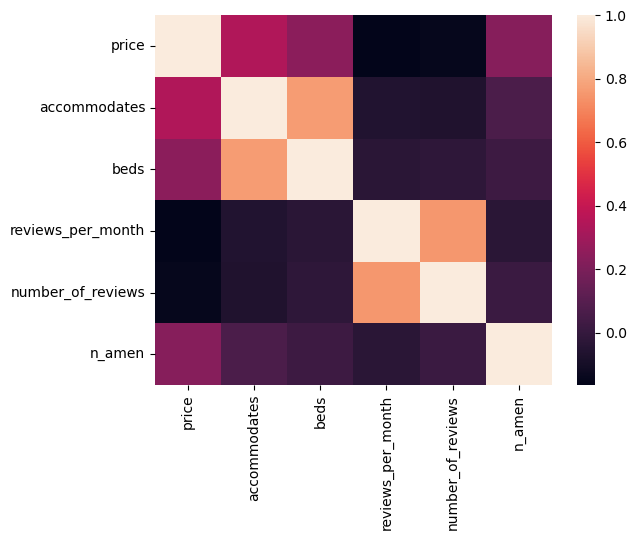

<Figure size 1000x800 with 0 Axes>

In [10]:
# Select specific columns
corr_df = df_tot[['price', 'accommodates', 'beds', 'reviews_per_month', 'number_of_reviews', 'n_amen']]
corr = corr_df.corr()
sns.heatmap(corr)

plt.figure(figsize=(10, 8))

We can see that the variables mostly correlated with price are the *beds* and *accomodates*, which are fairly similar variables. Also, they are not really indicative of anything, since it's quite obvious that if in a house can stay more people, it will cost more (and those people will share the cost). <br>
Thus, we construct a variable `ppp`, indicating *price per person*, obtained by dividing `price` by `accomodates`.

In [11]:
ppp_correlation = correlation_matrix['ppp'].drop(['ppp','price'])

# Sort the correlations by absolute value in descending order
sorted_price_correlation = ppp_correlation.sort_values(ascending=False)

print("Variables most correlated with price:")
print(sorted_price_correlation)

Variables most correlated with price:
Amsterdam                      0.216657
n_amen                         0.168249
availability_30                0.132940
review_scores_location         0.120180
review_scores_rating           0.105947
availability_365               0.090002
review_scores_cleanliness      0.088216
review_scores_accuracy         0.086468
review_scores_communication    0.076278
review_scores_checkin          0.068676
id                             0.064324
review_scores_value            0.055221
minimum_nights                -0.017882
host_id                       -0.035353
host_total_listings_count     -0.035992
maximum_nights                -0.043127
host_is_superhost             -0.074232
beds                          -0.094264
reviews_per_month             -0.119875
accommodates                  -0.119899
number_of_reviews             -0.120034
Rotterdam                     -0.137731
Hague                         -0.145007
Name: ppp, dtype: float64


These results are a bit more confusing: Amsterdam is the top correlated vaiables, hinting at higher prices for the Dutch capital. `review_scores_location` implies that better locations cost more: indeed, we theorize that the price is driven by location more than anything else. However there is still a (lower) correlation with `accomodates`. On the other hand, `n_amen` is now apparently irrelevant. 

## Quick interesting facts on the data

#### What are the most reviewed neighborhoods?

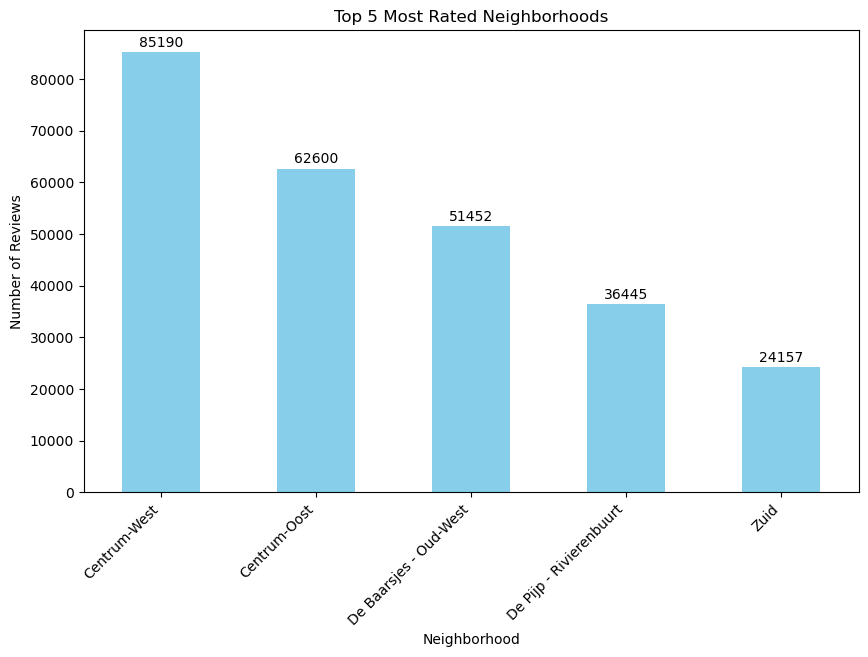

In [12]:
neigh_rev = df_tot.groupby('neighbourhood_cleansed')['number_of_reviews'].sum()
neigh_rev_sorted = neigh_rev.sort_values(ascending=False)

# 5 most reviewed neighborhoods
top_5_neigh = neigh_rev_sorted.head(5)

# Bar chart
plt.figure(figsize=(10, 6))
top_5_neigh.plot(kind='bar', color='skyblue')
plt.title('Top 5 Most Rated Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')

for index, value in enumerate(top_5_neigh): # put precise number on top of each bar
    plt.text(index, value + 500, str(value), ha='center', va='bottom')
    
plt.savefig('top_5_neigh.jpg', format='jpg', dpi=300)

plt.show()

In [13]:
# How many hosts and properties we have?
unique_prop = df_tot['id'].nunique()
unique_hosts = df_tot['host_id'].nunique()

print(unique_prop)
print(unique_hosts)
# When did the first host register to the AirBnB platform?
df_tot['host_since'] = pd.to_datetime(df_tot['host_since'])
oldest_host = df_tot['host_since'].min()
print(f"The 'oldest' host registerd on {oldest_host}\n")

# What is the property with the most reviews?
df_tot['number_of_reviews'].idxmax()
df_tot.iloc[3286]

# What is the house type with highest mean rating?
type_rating = df_tot.groupby('property_type')['review_scores_rating'].mean()
sorted_ratings = type_rating.sort_values(ascending=False)
print(f"Highest rated {sorted_ratings.head(5)}:\n") 
# this is not really explaining nothing, since we may have a single "Yurt" listing with a perfect rating

# What are the house types with the most reviews?
nrev_type = df_tot.groupby('property_type')['review_scores_rating'].count()
nrev_sorted = nrev_type.sort_values(ascending=False)
print(f"The number of reviews for each {nrev_sorted.head(5)}:\n")

# What is the average cost per person for each house type?
print(f"The avg price for each {df_tot.groupby('room_type')['ppp'].mean()}:")

6657
9234
The 'oldest' host registerd on 2008-09-24 00:00:00

Highest rated property_type
Yurt                        5.000000
Earthen home                5.000000
Private room                4.928333
Private room in bungalow    4.910000
Entire villa                4.896250
Name: review_scores_rating, dtype: float64:

The number of reviews for each property_type
Entire rental unit                   3834
Entire condo                         1689
Entire home                           909
Private room in rental unit           531
Private room in bed and breakfast     325
Name: review_scores_rating, dtype: int64:

The avg price for each room_type
Entire home/apt    88.075080
Hotel room         81.315000
Private room       62.128957
Shared room        47.091667
Name: ppp, dtype: float64:


In [14]:
# get neighbourhood dummies
print(f"Number of dimensions before neighborhood dummies:{df_tot.shape}") 
df_n = pd.get_dummies(df_tot, columns=['neighbourhood_cleansed'], prefix='')
print(f"Number of dimensions after neighborhood dummies: {df_n.shape}")

Number of dimensions before neighborhood dummies:(11027, 41)
Number of dimensions after neighborhood dummies: (11027, 224)


There are 183 total neighborhoods in our data. Adding a dummy for each may be a bit much, as we have just 11000 observations.

## Q2 Inferential statistics
We want to estimate how the number of amenities influences price.

We first implement a 'naive' regression of price on `n_amen`, `accomodates`, `review_scores_location`. <br>
We control for accomodates because we showed how the "size" of the house (obviously) influences price. Additionally, we use `review_score_location` as a proxy for the quality of the location. This will take into account the fact that houses in nicer locations will cost more, independently of the number of amenities.

In [15]:
# REGRESSION ON N_AMENITIES
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

ams['n_amen'] = ams['amenities'].apply(len) # get number of amenities for the analysis
X = ams[['n_amen', 'accommodates', 'review_scores_location']] # I should add the neighborhood var here and then unwind it.
y = ams['price']

Xy = pd.concat([X,y], axis = 1) # We concatenate the three datasets into a single one.
#X = Xy[['n_amen', 'accommodates', 'review_scores_location']]
#y = Xy['price']
Xy.dropna(inplace=True)

X = Xy[['n_amen', 'accommodates', 'review_scores_location']]
y = Xy['price']
y_log = np.log(y + 1)

In [16]:
model = LinearRegression()
model.fit(X,y)

# Coefficients 
coefficients = model.coef_
intercept = model.intercept_

# other variables we like to see
r_squared = model.score(X, y)
print("R-squared:", r_squared)
predictions = model.predict(X)
residuals = y - predictions

# Mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, predictions)
print("Mean Squared Error:", mse)

# Summary statistics
import statsmodels.api as sm
X_sm = sm.add_constant(X)  # Add constant for intercept in statsmodels
model_sm = sm.OLS(y, X_sm).fit()

# LATEX EXPORT
summary = model_sm.summary()
# Convert summary to LaTeX format
latex_summary = summary.as_latex()

# Save the LaTeX summary to a .tex file
with open('naive_reg_summary.tex', 'w') as f:
    f.write(latex_summary)

print(model_sm.summary())

R-squared: 0.1580829893906459
Mean Squared Error: 38371.005452250756
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     301.0
Date:                Sun, 30 Jun 2024   Prob (F-statistic):          4.50e-179
Time:                        23:49:39   Log-Likelihood:                -32230.
No. Observations:                4813   AIC:                         6.447e+04
Df Residuals:                    4809   BIC:                         6.449e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

### Regression diagnostics

#### Multicollinearity

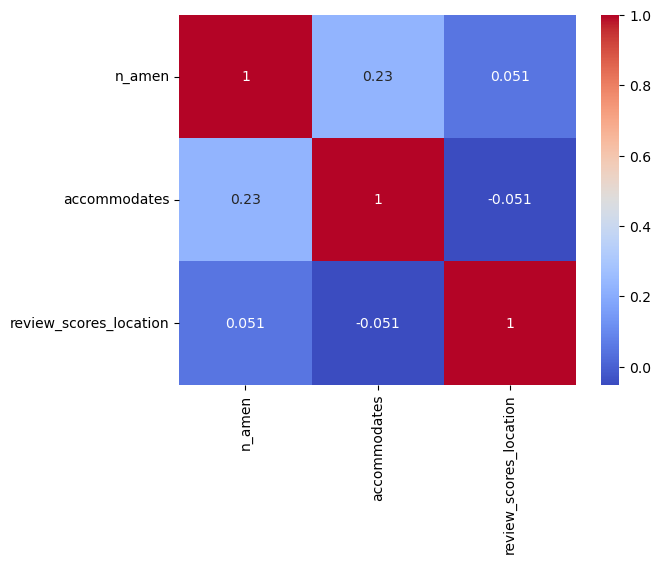

                 Variable         VIF
0                   const  338.015709
1                  n_amen    1.058750
2            accommodates    1.058765
3  review_scores_location    1.006830


In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

X_sm_vif = sm.add_constant(X)
vif = pd.DataFrame()
vif["Variable"] = X_sm_vif.columns
vif["VIF"] = [variance_inflation_factor(X_sm_vif.values, i) for i in range(X_sm_vif.shape[1])]
print(vif)

#### Outliers detection
According to both the correlation matrix and the VIF there are no multicollinearity problems. Let's check for outliers.

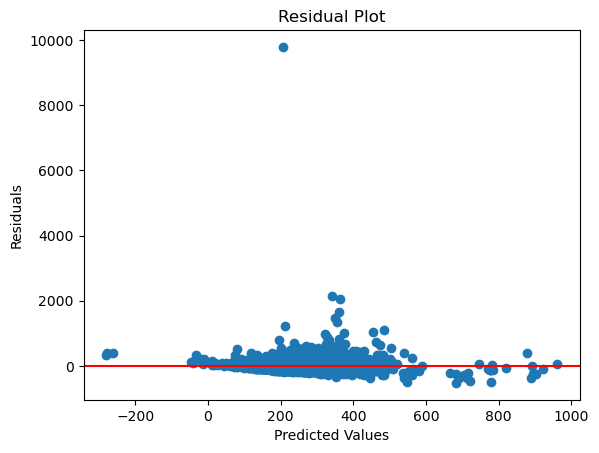

In [18]:
plt.scatter(predictions, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [19]:
# identify the outliers
outlier_index = residuals[residuals > 2000].index
print(outlier_index) # let's hard trim these. Not optimal but..

Index([440, 1707, 6669], dtype='int64')


#### Updated model
We update the model by getting rid of outliers, including squared terms and log-transforming price.

In [20]:
# Add squared terms:
X = X.copy()
X['acc2'] = X['accommodates']**2
X['n_amen2'] = X['n_amen']**2

# drop outliers
indices_to_drop = [440, 1707, 6669]
X_drop, y_drop = X.drop(indices_to_drop), y.drop(indices_to_drop)

# log transform price
y_log = np.log(y_drop)

In [21]:
# Fit the quadratic polynomial regression model with log-transformed price
model_poly_log = LinearRegression()
model_poly_log.fit(X_drop, y_drop) # CHANGE HERE y_drop -> y_log

# Coefficients and performance metrics
coefficients_poly_log = model_poly_log.coef_
intercept_poly_log = model_poly_log.intercept_
r_squared_poly_log = model_poly_log.score(X_drop, y_drop)# CHANGE HERE y_drop -> y_log
print("R-squared (log-transformed quadratic):", r_squared_poly_log)

# Predictions and residuals
predictions_poly_log = model_poly_log.predict(X_drop)
residuals_poly_log = y_drop - predictions_poly_log # CHANGE HERE y_drop -> y_log

# Mean squared error
mse_poly_log = mean_squared_error(y_drop, predictions_poly_log) # CHANGE HERE y_drop -> y_log

# Root mean squared error
rmse_poly_log = np.sqrt(mse_poly_log)
print("Root Mean Squared Error (log-transformed quadratic):", rmse_poly_log)

# Summary statistics using statsmodels
X_sm_poly_log = sm.add_constant(X_drop)
model_sm_poly_log = sm.OLS(y_drop, X_sm_poly_log).fit() # CHANGE HERE y_drop -> y_log
print(model_sm_poly_log.summary())

# LATEX EXPORT
summary_final = model_sm_poly_log.summary()
# Convert summary to LaTeX format
latex_summary = summary_final.as_latex()

# Save the LaTeX summary to a .tex file
with open('final_summary.tex', 'w') as f:
    f.write(latex_summary)

R-squared (log-transformed quadratic): 0.3163760070480318
Root Mean Squared Error (log-transformed quadratic): 127.5222919067106
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     444.7
Date:                Sun, 30 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:49:40   Log-Likelihood:                -30145.
No. Observations:                4810   AIC:                         6.030e+04
Df Residuals:                    4804   BIC:                         6.034e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025   

#### Conclusion:
With this updated regression we double our R-squared. However, the coefficient of `n_amen` is not statistically significant anymore. The squared term associated to the number of amenities is statistically different from zero, however the coefficient's value is extremely close to zero, implying no concrete price increase.

## Q1 Price prediction
We know attempt to develop a model that can predict price for each listing.
To fullfill this task we only focus on the Amsterdam dataset, as it contains 80%+ of the observations, while presenting just 22 neighbourhoods. Thus, we can integrate all neighborhood dummies with ease.


In [22]:
### LIBRARY IMPORT AND DATA PREP ####################################################
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler


# Extract AMS data from df_tot
amst = df_tot[df_tot['Amsterdam']==1] 
amst = amst[amst['price']<2000] # trim extremely high prices
amst = amst[['accommodates', 'neighbourhood_cleansed','price', 'availability_30', 
             'property_type', 'room_type', 'review_scores_location', 'review_scores_rating', 'beds']]

amst = amst.copy()
amst['acc2'] = amst['accommodates']**2
amst['acc3'] = amst['accommodates']**3
amst['beds2'] = amst['beds']**3
amst['beds3'] = amst['beds']**3


# get dummies from neighbourhoods
amst = pd.get_dummies(amst, columns=['neighbourhood_cleansed', 'property_type', 'room_type' ], drop_first=True)
amst.dropna(inplace=True)
# drop price NAs
#amst.dropna(subset=['price'], inplace=True) # 3000 Nas :( Maybe I can sub with the median

# Divide the dataset in explanatory and dependent variable
X = amst.drop(columns=['price'])
y = np.log(amst['price'])  # Log transform the target variable


In [23]:
### TRAIN TEST SPLIT AND SCALING #######################################

# train test split, 80% train
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# train val split, 75% train
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Standardize the data
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

In [24]:
# Ridge regression with cross-validation
alphas = np.logspace(-6, 6, 13)  # Range of alpha values to test
ridge_cv = RidgeCV(alphas=alphas, store_cv_results=True) # RidgeCV uses 5fold CV when samples are above 400, otherwise LOOCV.
ridge_cv.fit(X_train_val_scaled, y_train_val)

# Best alpha selected by cross-validation
best_alpha = ridge_cv.alpha_
print(f"Best alpha: {best_alpha}")

# Evaluate the model on the test set
ridge_final = Ridge(alpha=best_alpha)
ridge_final.fit(X_train_val_scaled, y_train_val)
y_pred_test = ridge_final.predict(X_test_scaled)

# Calculate Root Mean Squared Error (RMSE) on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Root Mean Squared Error on test set: {rmse_test}")



Best alpha: 1.0
Root Mean Squared Error on test set: 0.3564092376714958


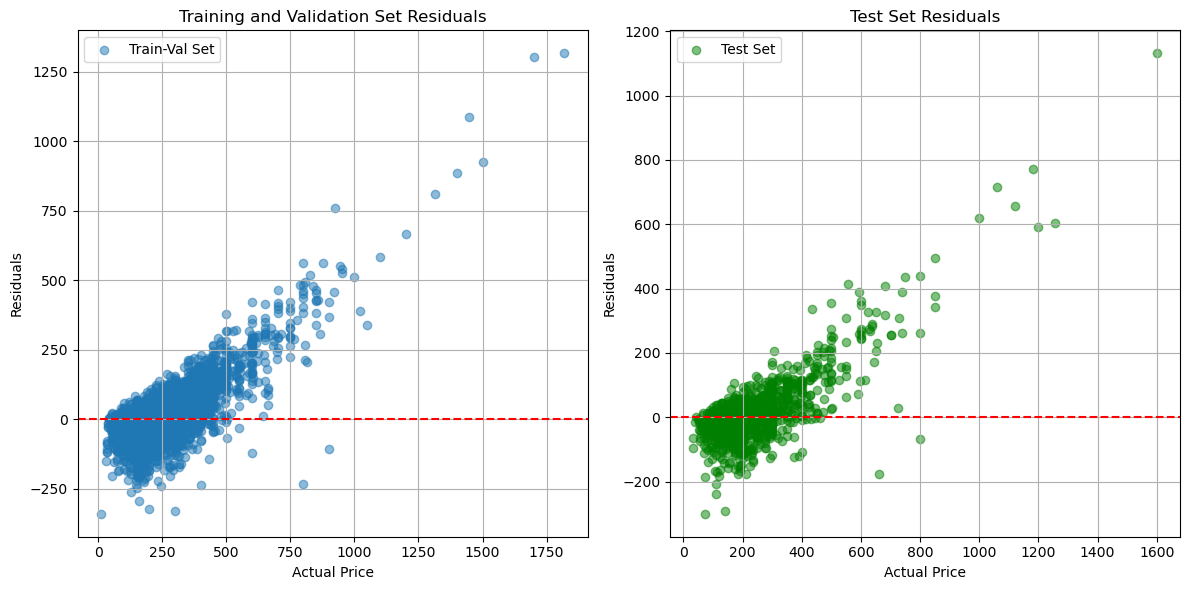

In [25]:
### EVALUATION OF BEST ALPHA IN LEVEL PRICE #############

# Fit Ridge regression model with best alpha on combined training and validation sets
ridge_final = Ridge(alpha=best_alpha)
ridge_final.fit(X_train_val_scaled, y_train_val)

# Predictions on combined training and validation sets
y_pred_train_val = ridge_final.predict(X_train_val_scaled)

# Inverse transform predictions and actual values
y_pred_train_val_original = np.exp(y_pred_train_val)
y_train_val_original = np.exp(y_train_val)
y_test_original = np.exp(y_test)

# Calculate residuals for training and validation sets
residuals_train_val = y_train_val_original - y_pred_train_val_original

# Calculate residuals for test set
y_pred_test = ridge_final.predict(X_test_scaled)
y_pred_test_original = np.exp(y_pred_test)
residuals_test = y_test_original - y_pred_test_original

# Plot residuals for training, validation, and test sets
plt.figure(figsize=(12, 6))

# Training and Validation Set Residuals
plt.subplot(1, 2, 1)
plt.scatter(y_train_val_original, residuals_train_val, alpha=0.5, label='Train-Val Set')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Residuals')
plt.title('Training and Validation Set Residuals')
plt.legend()
plt.grid(True)

# Test Set Residuals
plt.subplot(1, 2, 2)
plt.scatter(y_test_original, residuals_test, alpha=0.5, color='g', label='Test Set')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Residuals')
plt.title('Test Set Residuals')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('residuals_plot.jpg', format='jpg', dpi=300)

plt.show()

The model exhibit systematic bias across price levels. Are we missing some variables?

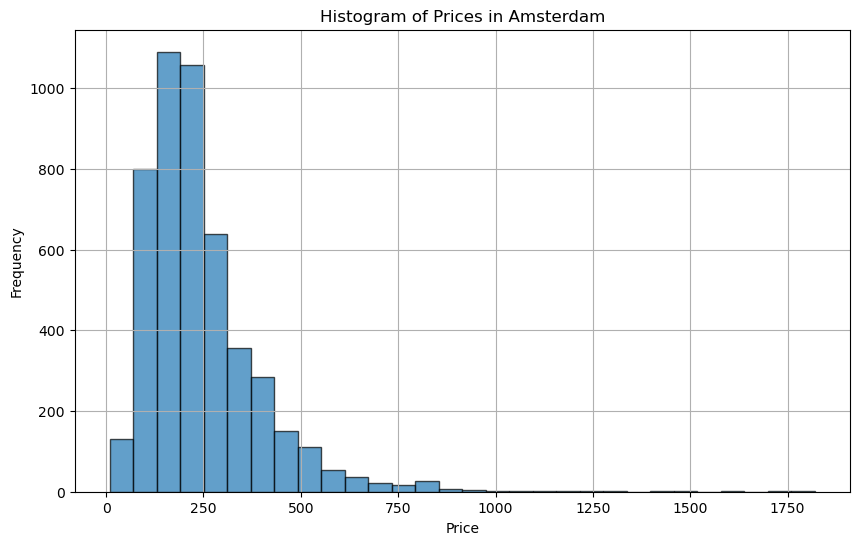

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(amst['price'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Prices in Amsterdam')
plt.grid(True)
plt.show()

## Q3 PCA and Clustering
For now this just focuses on Amsterdam's dataset

In [27]:
from sklearn.preprocessing import StandardScaler
ams_num = ams.select_dtypes(include='number')
ams_num = ams_num.dropna()
columns_to_drop = ['id', 'host_id', 'minimum_nights',
                  'maximum_nights','availability_365', 'Amsterdam']
ams_num.drop(columns=columns_to_drop, inplace=True)
# Assuming X is your dataset as a numpy array or pandas DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ams_num)

In [28]:
from sklearn.decomposition import PCA
# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to the scaled data
principal_components = pca.fit_transform(X_scaled)

# Extract the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f'Explained variance ratio: {explained_variance_ratio}')

Explained variance ratio: [0.31390209 0.14639579]


In [29]:
loadings = pca.components_
# Get feature names
feature_names = ams_num.columns

# Print associated variables (features) with loadings
for i, pc in enumerate(loadings):
    print(f"\nPrincipal Component {i+1}:")
    for j, feature in enumerate(feature_names):
        print(f"{feature}: {pc[j]}")


Principal Component 1:
host_total_listings_count: -0.05628313847338244
accommodates: -0.00668125031394021
beds: -0.019950018767606922
price: 0.06413440031237727
availability_30: -0.0663624879767403
number_of_reviews: -0.028652372244638485
review_scores_rating: 0.414478703047539
review_scores_accuracy: 0.4020134476589446
review_scores_cleanliness: 0.35472888272867453
review_scores_checkin: 0.36227471470639655
review_scores_communication: 0.3844275935770803
review_scores_location: 0.30211294370299596
review_scores_value: 0.38058202973463984
reviews_per_month: -0.041006650461768324
n_amen: 0.10482088383686898

Principal Component 2:
host_total_listings_count: -0.02827648486467906
accommodates: 0.561484500239378
beds: 0.5227387722562912
price: 0.39901918557192667
availability_30: -0.03961748139921234
number_of_reviews: -0.29404789278168203
review_scores_rating: 0.004193945662307211
review_scores_accuracy: -0.022500883193268886
review_scores_cleanliness: -0.05715708838770921
review_scores_

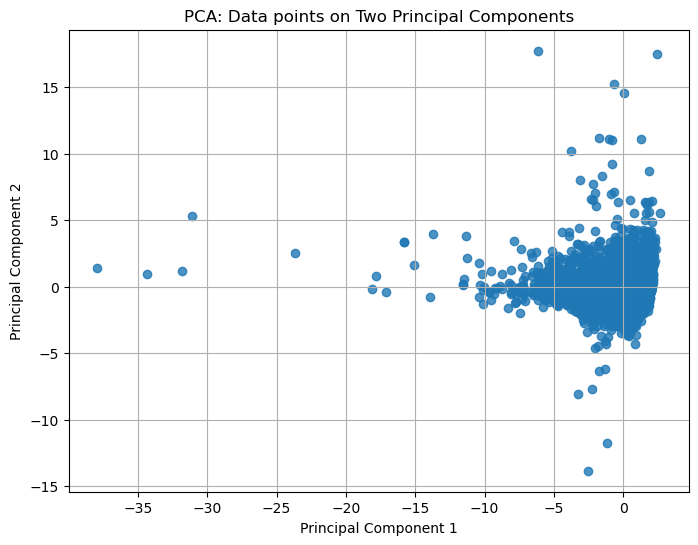

In [30]:
import matplotlib.pyplot as plt

# Plotting the principal components
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.8)
plt.title('PCA: Data points on Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)


plt.savefig('pca.jpg', format='jpg', dpi=300)
plt.show()

We try to get rid of the outliers on the left to see how the plot is rescaled.

In [31]:
threshold = -20
filtered_indices = principal_components[:, 0] >= threshold

# Create filtered dataset
filtered_data = ams_num[filtered_indices]

# Check the shape of filtered data
print("Shape of filtered data:", filtered_data.shape)

Shape of filtered data: (4797, 15)


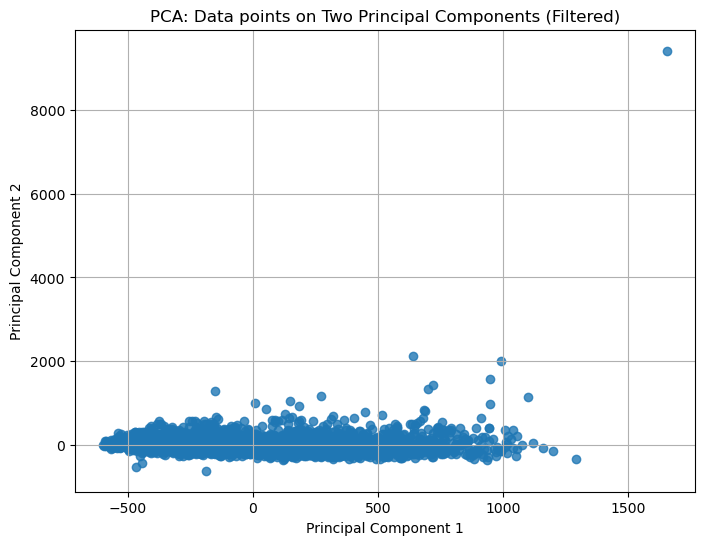

In [32]:
import matplotlib.pyplot as plt

# Perform PCA on the filtered data
pca_filtered = PCA(n_components=2)
principal_components_filtered = pca_filtered.fit_transform(filtered_data)

# Plotting the principal components
plt.figure(figsize=(8, 6))
plt.scatter(principal_components_filtered[:, 0], principal_components_filtered[:, 1], alpha=0.8)
plt.title('PCA: Data points on Two Principal Components (Filtered)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

Very bad. We conclude no clustering.

## Additional Code for Q2 (First two subsections)
The code below has been used to answer the first two subsections of Q2. Unfortunately, at the moment this code does not run properly, but we leave it here to show the work that has been done:

In [33]:
required_columns = ["availability_30",
       "availability_365", "review_scores_rating", 'city', "amenities"] # issue is that I do not have a "city" variable in my df_tot
df_cleaned = df_tot[required_columns].dropna()

In [34]:
unique_texts = set()
text_column = df_cleaned["amenities"]
for text in text_column:
    # Check if the text is already in the set
    if text not in unique_texts:
        # If not in set, add to set and concatenate to a single string
        unique_texts.add(text)
len(unique_texts)

7853

In [35]:
freq_amen = {}
# Group by 'city' and process the amenities
grouped_city = df_cleaned.groupby('city')
for city, group in grouped_city:
    
        text_column = group['amenities']
        all_text = ' '.join(text_column.dropna()).strip()
    
        words = [word.strip() for word in all_text.split(",")]
        word_freq = Counter(words)
        freq_amen[city] = {word: freq for word, freq in word_freq.most_common(20)} 

# Extract top amenities for each city and store them in the dictionary
for city, amenities in freq_amen.items():
    print(f"Most common amenities in {city}:")
    for amenity, freq in amenities.items():
        print(f'  {amenity}: {freq}')
    print()

Most common amenities in Amsterdam:
  "Smoke alarm": 7219
  "Dishes and silverware": 6456
  "Hot water": 6402
  "Wifi": 6101
  "Hair dryer": 5972
  "Essentials": 5929
  "Refrigerator": 5890
  "Hangers": 5788
  "Bed linens": 5741
  "Iron": 5511
  "Kitchen": 5280
  "Carbon monoxide alarm": 4657
  "Heating": 4560
  "Shampoo": 4442
  "Dishwasher": 4413
  "Dedicated workspace": 4062
  "Washer": 3990
  "Cleaning products": 3934
  "Fire extinguisher": 3892
  "Hot water kettle": 3749

Most common amenities in Hague:
  [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [

In [36]:
# Summarize the top 20 'amenities' 
amenities_list = df_cleaned['amenities'].dropna().str.split(',').explode().str.strip()
top_amenities = amenities_list.value_counts().head(20)
top_amenities

amenities
"Smoke alarm"              7219
"Dishes and silverware"    6456
"Hot water"                6402
"Wifi"                     6101
"Hair dryer"               5972
"Essentials"               5929
"Refrigerator"             5890
"Hangers"                  5788
"Bed linens"               5741
"Iron"                     5511
"Kitchen"                  5280
"Carbon monoxide alarm"    4657
"Heating"                  4560
"Shampoo"                  4442
"Dishwasher"               4413
"Dedicated workspace"      4062
"Washer"                   3990
"Cleaning products"        3934
"Fire extinguisher"        3892
"Hot water kettle"         3749
Name: count, dtype: int64

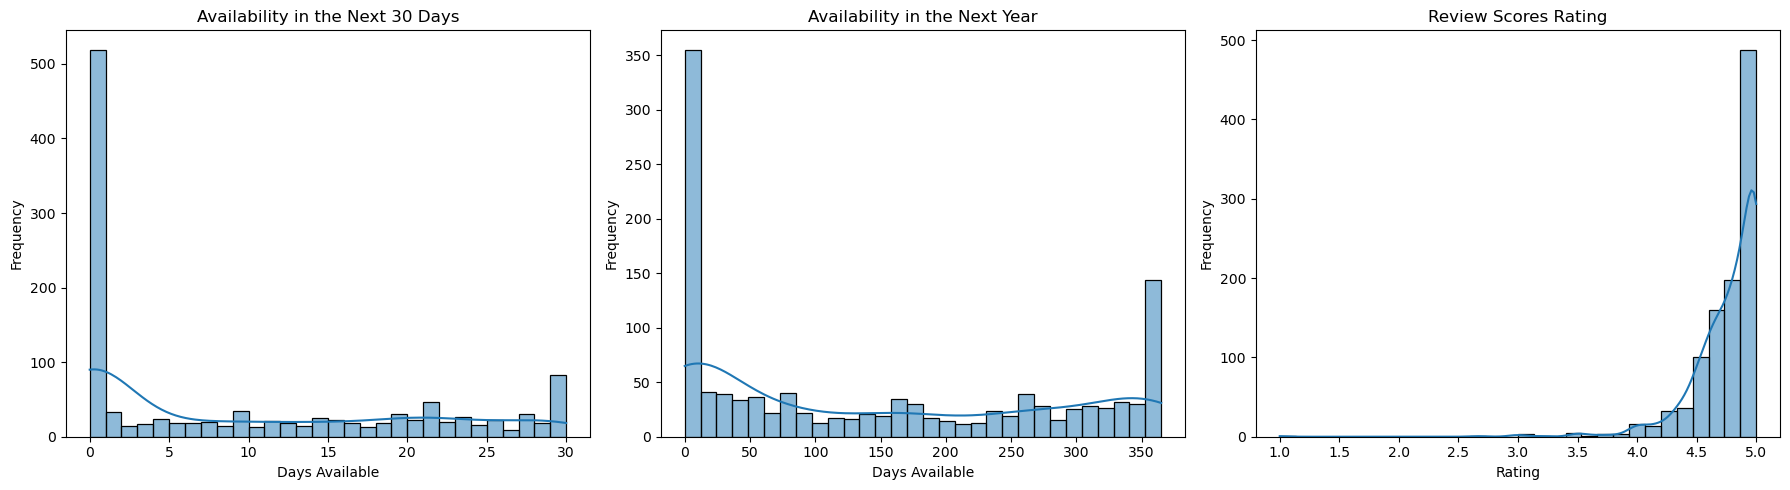

,availability_30,availability_365,review_scores_rating
availability_30,1.000000,0.682183,-0.134559
availability_365,0.682183,1.000000,-0.139694
review_scores_rating,-0.134559,-0.139694,1.000000


In [37]:
# Compute correlations between review scores and availability
correlations = df_cleaned[['availability_30', 'availability_365', 'review_scores_rating']].corr()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution of availability_30
sns.histplot(df['availability_30'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Availability in the Next 30 Days')
axes[0].set_xlabel('Days Available')
axes[0].set_ylabel('Frequency')


sns.histplot(df['availability_365'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Availability in the Next Year')
axes[1].set_xlabel('Days Available')
axes[1].set_ylabel('Frequency')


sns.histplot(df['review_scores_rating'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Review Scores Rating')
axes[2].set_xlabel('Rating')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Show correlations
correlations


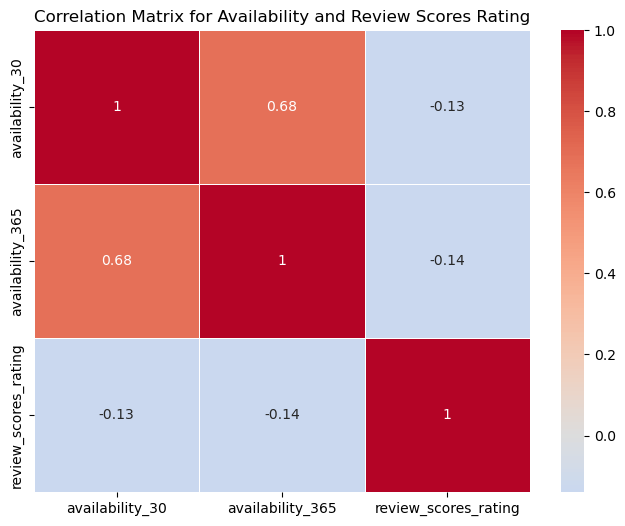

In [38]:
# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0, linewidths=.5)
plt.title('Correlation Matrix for Availability and Review Scores Rating')
plt.show()

In [39]:
for amenity in top_amenities.index:
    df_cleaned[amenity] = df_cleaned['amenities'].str.contains(amenity).fillna(False)

# Calculate mean review scores and availability for listings with and without top amenities
amenity_impact = {
    'amenity': [],
    'mean_review_score': [],
    'mean_availability_30': [],
    'mean_availability_365': []
}

for amenity in top_amenities.index:
    mean_review_score = df_cleaned.groupby(amenity)['review_scores_rating'].mean()
    mean_availability_30 = df_cleaned.groupby(amenity)['availability_30'].mean()
    mean_availability_365 = df_cleaned.groupby(amenity)['availability_365'].mean()
    
    amenity_impact['amenity'].append(amenity)
    amenity_impact['mean_review_score'].append(mean_review_score[True])
    amenity_impact['mean_availability_30'].append(mean_availability_30[True])
    amenity_impact['mean_availability_365'].append(mean_availability_365[True])

# Convert the impact data into a DataFrame for easier visualization
amenity_impact_df = pd.DataFrame(amenity_impact)

# Show the DataFrame
amenity_impact_df.sort_values(by='mean_review_score', ascending=False)

,amenity,mean_review_score,mean_availability_30,mean_availability_365
17,"""Cleaning products""",4.876080,4.145907,66.274021
14,"""Dishwasher""",4.867415,3.745813,59.341557
19,"""Hot water kettle""",4.867191,4.440384,71.226460
1,"""Dishes and silverware""",4.856327,4.004797,64.534736
9,"""Iron""",4.854920,4.034470,65.213353
10,"""Kitchen""",4.854640,3.837087,59.148348
6,"""Refrigerator""",4.851251,4.019081,64.080885
2,"""Hot water""",4.849704,4.112968,66.106004
8,"""Bed linens""",4.849181,4.337398,69.943041
11,"""Carbon monoxide alarm""",4.848473,4.432247,69.684177


C:\Users\lucap\AppData\Local\Temp\ipykernel_9720\750906481.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


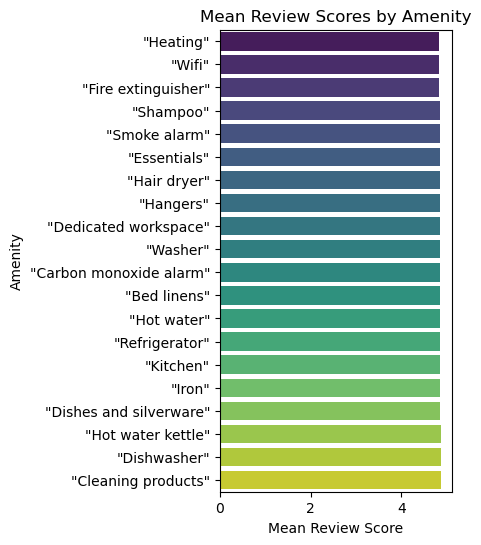

C:\Users\lucap\AppData\Local\Temp\ipykernel_9720\750906481.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


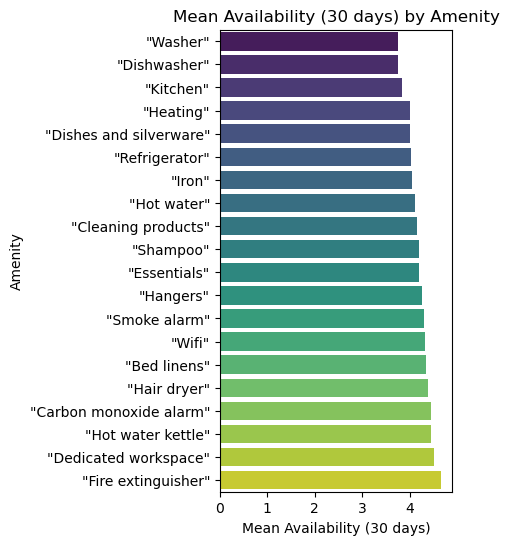

C:\Users\lucap\AppData\Local\Temp\ipykernel_9720\750906481.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


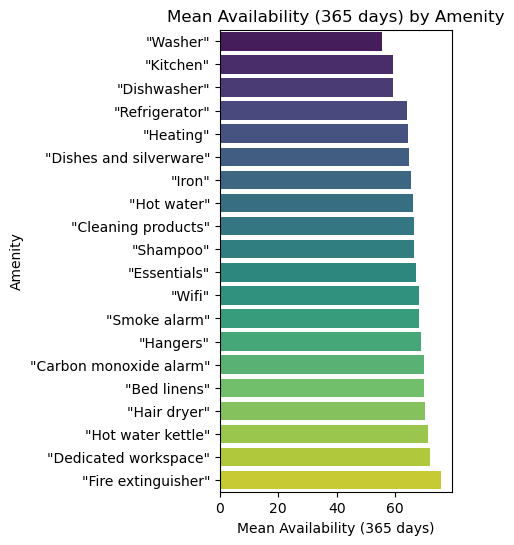

In [40]:
# Plot mean review scores by amenity with error bars
plt.figure(figsize=(3, 6))
sns.barplot(
    x='mean_review_score', 
    y='amenity', 
    data=amenity_impact_df.sort_values(by='mean_review_score', ascending=True), 
    palette='viridis', 
   
)
plt.title('Mean Review Scores by Amenity')
plt.xlabel('Mean Review Score')
plt.ylabel('Amenity')
plt.show()

# Plot mean availability for 30 days by amenity with error bars
plt.figure(figsize=(3, 6))
sns.barplot(
    x='mean_availability_30', 
    y='amenity', 
    data=amenity_impact_df.sort_values(by='mean_availability_30', ascending=True), 
    palette='viridis'
)
plt.title('Mean Availability (30 days) by Amenity')
plt.xlabel('Mean Availability (30 days)')
plt.ylabel('Amenity')
plt.show()

# Plot mean availability for 365 days by amenity with error bars
plt.figure(figsize=(3, 6))
sns.barplot(
    x='mean_availability_365', 
    y='amenity', 
    data=amenity_impact_df.sort_values(by='mean_availability_365', ascending=True), 
    palette='viridis', 
)
plt.title('Mean Availability (365 days) by Amenity')
plt.xlabel('Mean Availability (365 days)')
plt.ylabel('Amenity')
plt.show()


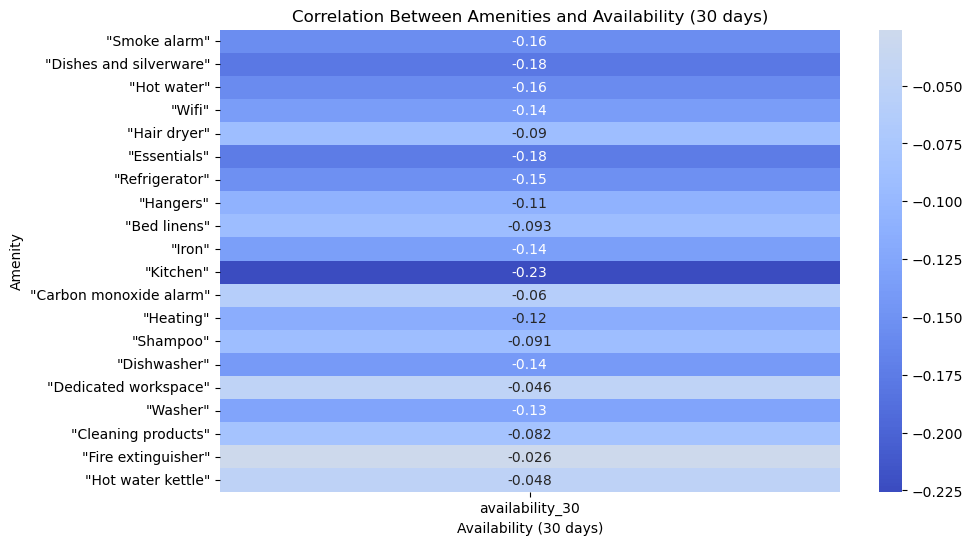

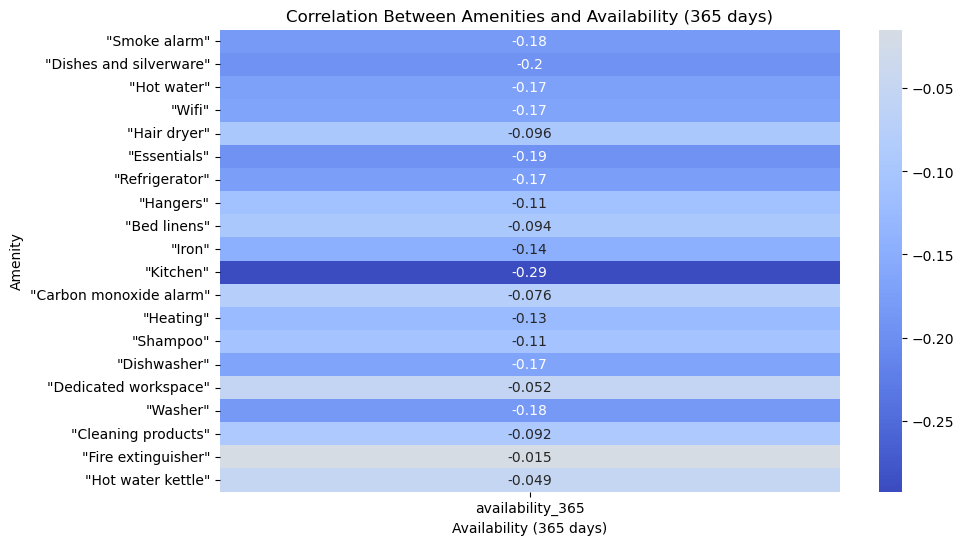

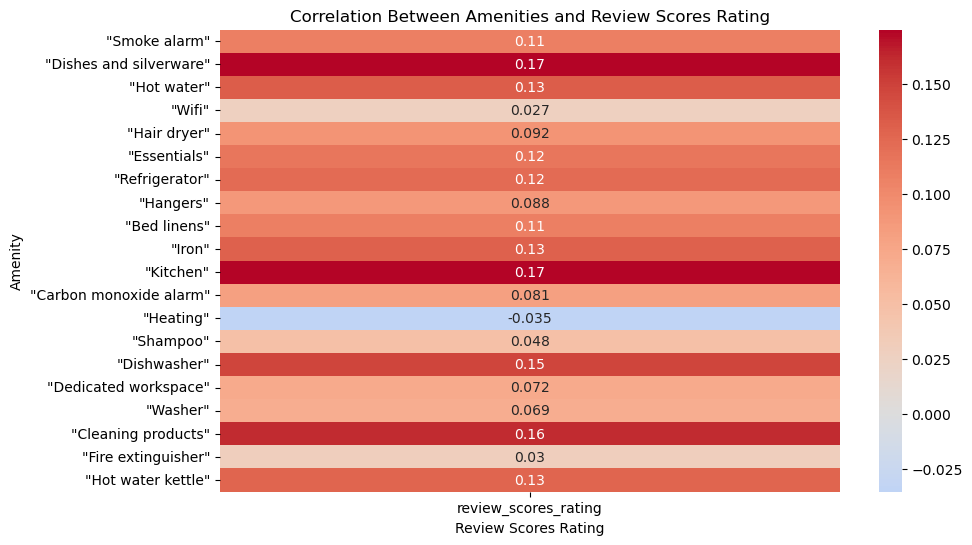

In [41]:
# Summarize the 'amenities' column by listing the most common amenities
amenities_list = df_cleaned['amenities'].dropna().str.split(',').explode().str.strip()
top_amenities = amenities_list.value_counts().head(20)

# Create columns for the presence of top amenities
for amenity in top_amenities.index:
    df_cleaned[amenity] = df_cleaned['amenities'].str.contains(amenity).fillna(False)

# Calculate correlations between the presence of amenities and availability metrics
amenity_columns = top_amenities.index.tolist()
correlation_matrix_30 = df_cleaned[amenity_columns + ['availability_30']].corr()['availability_30'].drop('availability_30')
correlation_matrix_365 = df_cleaned[amenity_columns + ['availability_365']].corr()['availability_365'].drop('availability_365')
correlation_matrix_rating = df_cleaned[amenity_columns + ['review_scores_rating']].corr()['review_scores_rating'].drop('review_scores_rating')
# Plot the correlation heatmaps
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_30.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Amenities and Availability (30 days)')
plt.xlabel('Availability (30 days)')
plt.ylabel('Amenity')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_365.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Amenities and Availability (365 days)')
plt.xlabel('Availability (365 days)')
plt.ylabel('Amenity')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_rating.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Amenities and Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Amenity')
plt.show()